This notebook features a random forests classifier. After training KNN and SVM models, we decided to spend the remaining time fitting a random forests model. For this model, we used an iteratively imputed dataset, which performed best in our KNN and SVM models. We'll begin by importing the data and the sklearn packages.

In [153]:
import numpy as np 
import pandas as pd

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer # for iterative imputation
from sklearn.model_selection import train_test_split # for splitting the training set into a train and test set.
from sklearn.metrics import roc_curve # for finding roc curves for learners
from sklearn.metrics import auc # for determining auc for learners
import matplotlib.pyplot as plt # for generating plots

filename_train = "./GiveMeSomeCredit/cs-training.csv"
train = pd.read_csv(filename_train, index_col = 0) 
train.reset_index(drop = True, inplace = True)
trainX = train.iloc[:, 1:11]
trainy = train.iloc[:,0]

Next we will clean the data, following the procedure from our previous models. This time, we will only work with our highest-performing dataset, which was iteratively imputed. To summarize this our process again:

We begin with thresholding the outliers in three columns: Number of times Late, Revolving Utilization, and Debt Ratio...

In [154]:
train = train[(train["NumberOfTime60-89DaysPastDueNotWorse"] < 96) & (train["NumberOfTimes90DaysLate"] < 96) & (train["NumberOfTime30-59DaysPastDueNotWorse"] < 96)]
train = train[train["RevolvingUtilizationOfUnsecuredLines"] <= train["RevolvingUtilizationOfUnsecuredLines"].quantile(0.999)]
train = train[train["DebtRatio"] <= train["DebtRatio"].quantile(0.99)]

Followed by iteratively imputing values...

In [155]:
train.reset_index(drop = True, inplace = True)
trainX = train.iloc[:, 1:11]
trainy = train.iloc[:,0]

imp_mean = IterativeImputer(random_state=0) # use iterative imputer to fill missing values
imp_mean.fit(trainX)
train = pd.DataFrame(imp_mean.transform(trainX))

And standardizing the values for each attribute.

In [156]:
trainy = trainy[train[9] >= 0]
train = train[train[9] >= 0]
train.reset_index(drop = True, inplace = True)

trainX = train
trainy = trainy
trainX = (trainX - trainX.mean())/trainX.std()

trainX.shape

(147869, 10)

We will now fit a Random Forests classifier using Scikit-Learn's builtin library. To illustrate how the model scales with forest size, we will use forests of size 10, 50, 100, and 200 trees.

Similar to our other models, we perform an 80:20 split for testing and training data. Bootstrapping is used during the fitting process to generate training data.

In [177]:
forests = [10,50,100,200]
ROCs = []  # Holds the ROC curves for plotting later

for N in forests:
    # Fit the model for N trees
    trainX1, trainX2, trainy1, trainy2 = train_test_split(trainX, trainy, test_size=0.2)
    clf = RandomForestClassifier(n_estimators=N, max_depth=None,min_samples_split=2)
    clf.fit(trainX1,trainy1)
    
    # Score the model and record the information for the ROC curve
    y_scores = clf.predict_proba(trainX2)
    fpr, tpr, threshold = roc_curve(trainy2, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)
    
    ROCs.append((fpr,tpr,roc_auc))

Below are the ROC curves for each of our models:

No handles with labels found to put in legend.


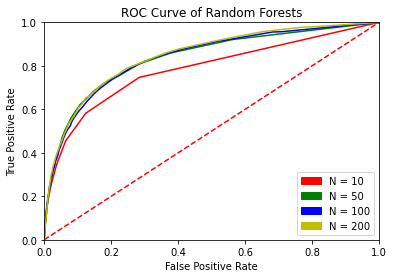

AUCs per N


[(10, 0.7817302015884697),
 (50, 0.8369071138098975),
 (100, 0.8387068042024962),
 (200, 0.8457949269341675)]

In [193]:
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Random Forests')

for i in range(len(ROCs)):
    plt.plot(ROCs[i][0], ROCs[i][1], c=line_colors[i], label = 'AUC = %0.2f' % ROCs[i][2])

line_colors = ['r','g','b','y']
pop_a = mpatches.Patch(color='r', label='N = 10')
pop_b = mpatches.Patch(color='g', label='N = 50')
pop_c = mpatches.Patch(color='b', label='N = 100')
pop_d = mpatches.Patch(color='y', label='N = 200')

plt.legend(handles=[pop_a,pop_b,pop_c,pop_d])

plt.show()

AUCs = [(forests[i],ROCs[i][2]) for i in range(len(ROCs))]

print("AUCs per N")
AUCs

The model appears to approach an AUC of .85 (running some more long simulations with n>1000 supports this). Quite good, our best yet. Are we overfitting though? Let's see how the RF model performs on Kaggle's test dataset. We will use a forest of size n=200,
set the minimum samples per split to be 2, and leave the maximum depth undetermined. Bootstrapping will be used during the fitting process.

In [172]:
filename_test = "./GiveMeSomeCredit/cs-test.csv"
testX = pd.read_csv(filename_test, index_col = 0) 

testX = testX.iloc[:, 1:]

testXf1 = pd.DataFrame(imp_mean.transform(testX))

testXf1 = (testXf1 - testXf1.mean())/testXf1.std()
testXf2 = (testXf2 - testXf2.mean())/testXf2.std()

trainX1, trainX2, trainy1, trainy2 = train_test_split(trainX, trainy, test_size=0.2)
clf = RandomForestClassifier(n_estimators=200, max_depth=None,min_samples_split=2, max_leaf_nodes=10, min_samples_leaf=50,n_jobs=-1)
clf.fit(trainX1, trainy1)

y_iterative = clf.predict_proba(testXf1)
y_iterative = pd.DataFrame(y_iterative)
y_iterative = y_iterative.iloc[:,1]
y_iterative

Kaggle gives us an AUC of .639. Definitely not as well as our training set, and marginally better than KNN. However, random forests has many hyperparameters beyond our original settings, including inheriting many of the parameters of decision trees. Some of these include:
- Maximum number of terminal nodes
- Minimum number of samples per leaf
- Maximum number of samples
- Maximum number of features
With some tweaking, we can beef up the predictive power of our model. Here's what we got with some fiddling:

Minimum samples/leaf = 25 --> AUC = .655

Minimum samples/leaf = 50 --> AUC = .685

Maximum terminal nodes = 10 --> AUC = .748

Maximum terminal nodes = 10 AND Minimum samples/leaf = 50 --> AUC = .73

By setting the minimum samples/leaf, we can control the growth of the tree. When trees have too few samples, we run the risk of overfitting the data. This is likely our situation, since CV gave us pretty good results when we were working with the training data.

Setting the maximum number of terminal nodes also provides another means for controlling the growth of the tree. A tree will stop splitting if the number of child nodes is larger than this value. If this value is too small, we run the risk of underfitting. 

With some more time, we would generate graphs for all of these hyperparamaters. For now, guess-and-check will have to do. It's clear there's a delicate balance here - tweaking these two parameters individual enhanced the model, but the combination of them wasn't optimal.